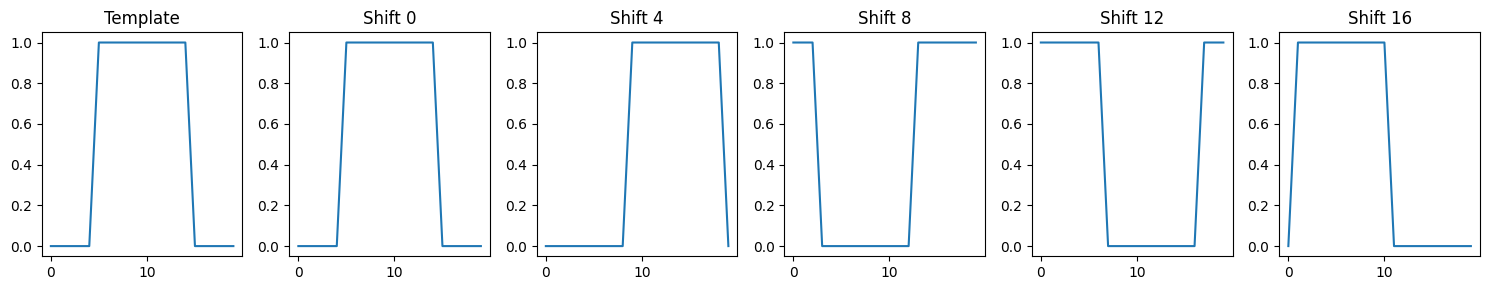

In [6]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Generate template array and dataset
n = 20  # Size of array
template = np.zeros(n)
template[n//4:3*n//4] = 1  # Create a box signal

# Generate dataset by rolling
arrays = []
shifts = []
for k in range(n):
    arrays.append(np.roll(template, k))
    shifts.append(k)
arrays = np.array(arrays)
shifts = np.array(shifts)

# Plot template and some rolled versions
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.plot(template)
plt.title('Template')
for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.plot(arrays[i*4])
    plt.title(f'Shift {i*4}')
plt.tight_layout()
plt.show()



In [7]:
torch.combinations(torch.tensor([2., 3., 4.]), 2)

tensor([[2., 3.],
        [2., 4.],
        [3., 4.]])

In [8]:
# Create neural network
class AdditionArrays(nn.Module):
    def __init__(self, n, mi=1, mj=1):
        super().__init__()
        self.fc1_u_v = nn.Linear(2*n, n)
        self.fc2_w = nn.Linear(n, n)
        self.mi = mi
        self.mj = mj
        
    def forward(self, x):
        x = self.fc1_u_v(x)
        x = x ** (self.mi + self.mj) # Nonlinearity depends on mi and mj
        x = self.fc2_w(x)
        return x

# Create custom dataset
class ArrayShiftDataset(Dataset):
    def __init__(self, arrays, shifts, mi=1, mj=1):
        self.arrays = torch.FloatTensor(arrays)
        self.shifts = torch.LongTensor(shifts)
        self.x = torch.zeros((len(self.arrays) * len(self.arrays), 2 * n))
        self.y = torch.zeros((len(self.arrays) * len(self.arrays), n))
        for i in range(len(self.arrays)):
            for j in range(len(self.arrays)):
                self.x[i * len(self.arrays) + j] = torch.cat([self.arrays[i], self.arrays[j]])
                self.y[i * len(self.arrays) + j] = self.arrays[(i * mi + j * mj) % len(self.arrays)]
        
    def __len__(self):
        # all possible combinations of two arrays
        return len(self.arrays) * len(self.arrays)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset and dataloader
mi = 2
mj = 3
dataset = ArrayShiftDataset(arrays, shifts, mi=mi, mj=mj)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


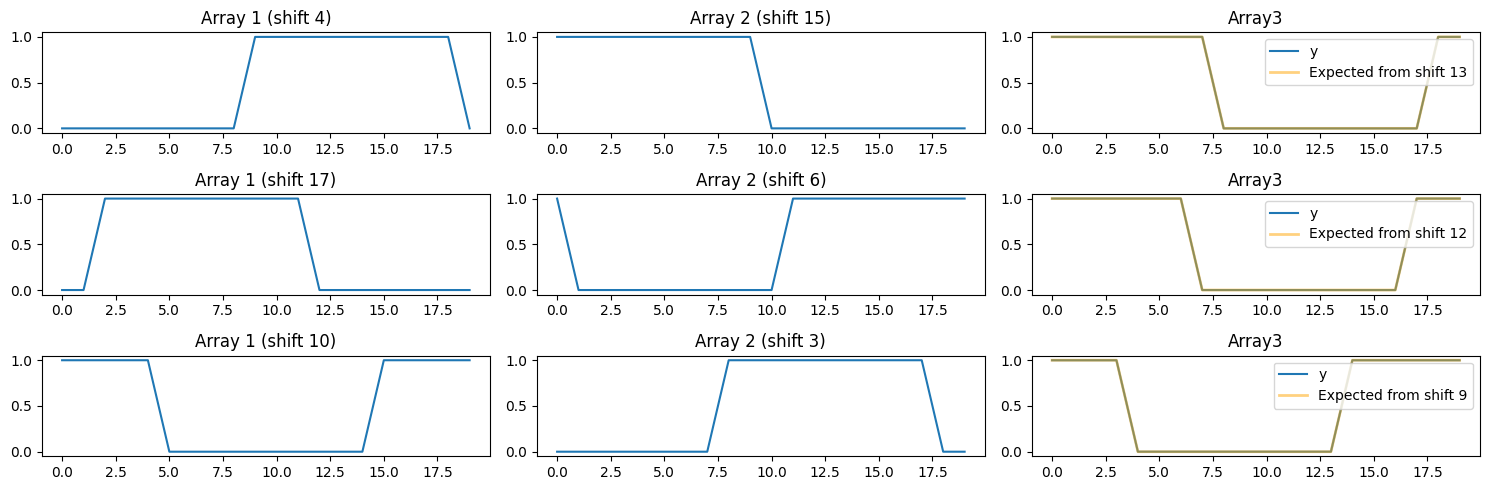

In [9]:
# Plot a few examples from the dataset to check that the dataset is correct
plt.figure(figsize=(15,5))
for i in range(3):
    # Get a random sample from dataset
    idx = np.random.randint(len(dataset))
    x, y = dataset[idx]
    
    # Split the data back into the two original arrays
    array1 = x[:n]
    array2 = x[n:]
    array3 = y
    
    # Find the original indices and shifts
    # Possible to get the indices from the dataset because the dataset is not shuffled
    idx1 = idx // len(arrays)
    idx2 = idx % len(arrays)
    shift1 = shifts[idx1]
    shift2 = shifts[idx2]
    
    # Plot on the current row
    plt.subplot(3, 3, i*3 + 1)
    plt.plot(array1)
    plt.title(f'Array 1 (shift {shift1})')
    
    plt.subplot(3, 3, i*3 + 2)
    plt.plot(array2)
    plt.title(f'Array 2 (shift {shift2})')
    
    
    plt.subplot(3, 3, i*3 + 3)
    plt.plot(array3, label='y')
    plt.title(f'Array3')
    # Plot the expected array (shifted by shift1 + shift2)
    plt.plot(arrays[(shift1*mi + shift2*mj) % len(arrays)], 'orange', label=f'Expected from shift {(shift1*mi + shift2*mj) % len(arrays)}', alpha=0.5, linewidth=2)
    plt.legend()

plt.tight_layout()
plt.show()


Epoch 100/3000, Loss: 0.084382


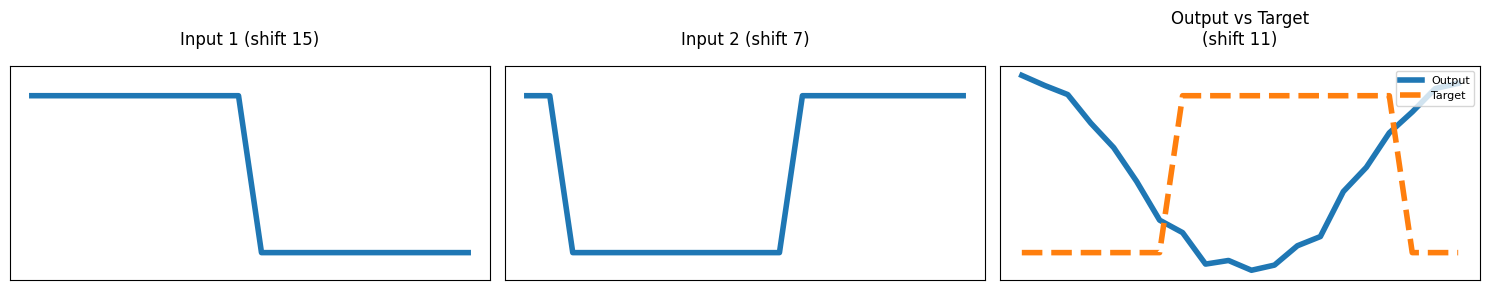

Epoch 200/3000, Loss: 0.076282


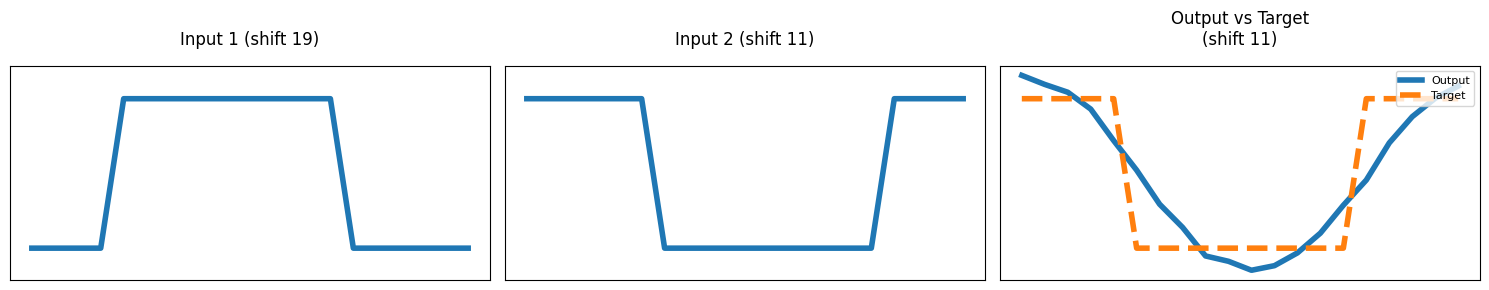

Epoch 300/3000, Loss: 0.080683


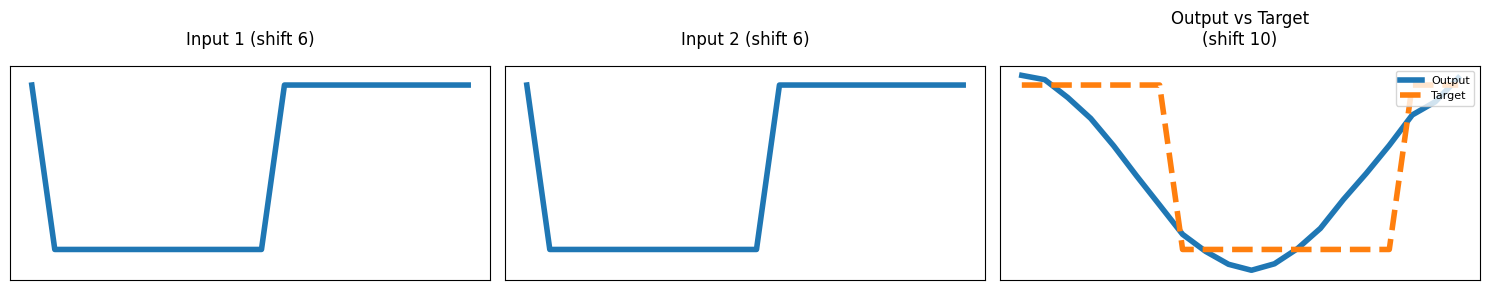

Epoch 400/3000, Loss: 0.064551


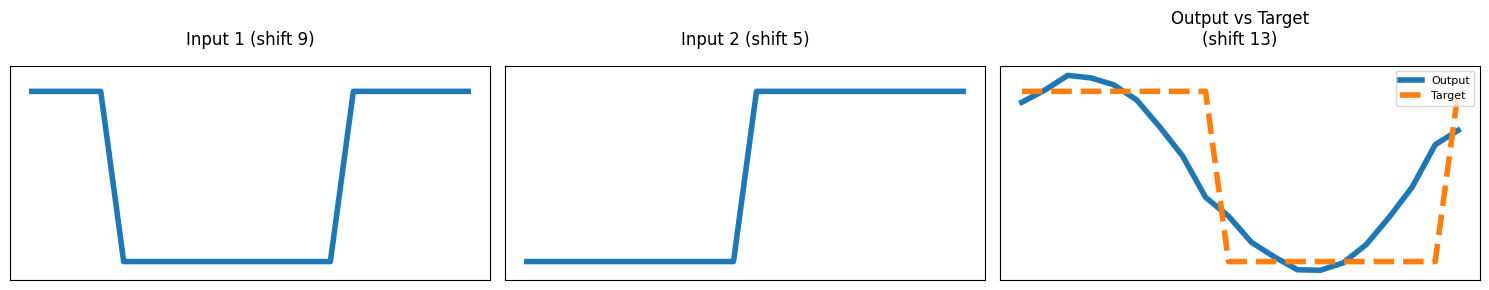

Epoch 500/3000, Loss: 0.055165


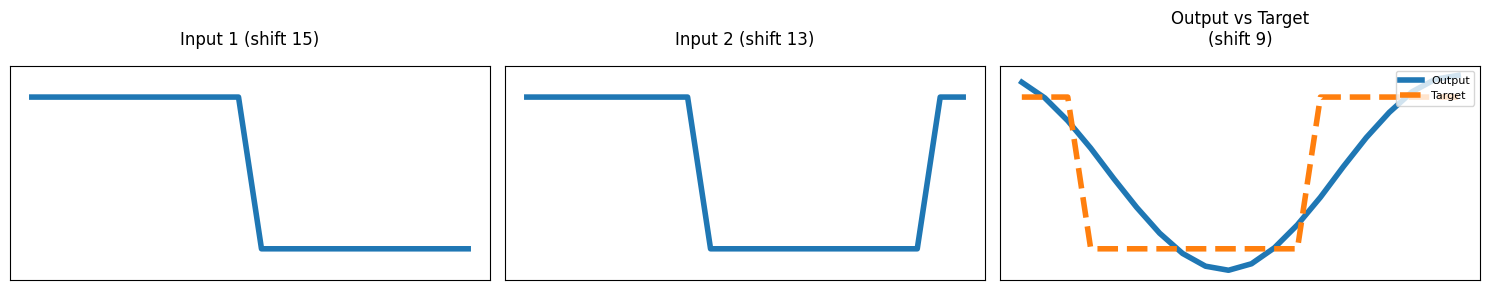

Epoch 600/3000, Loss: 0.058693


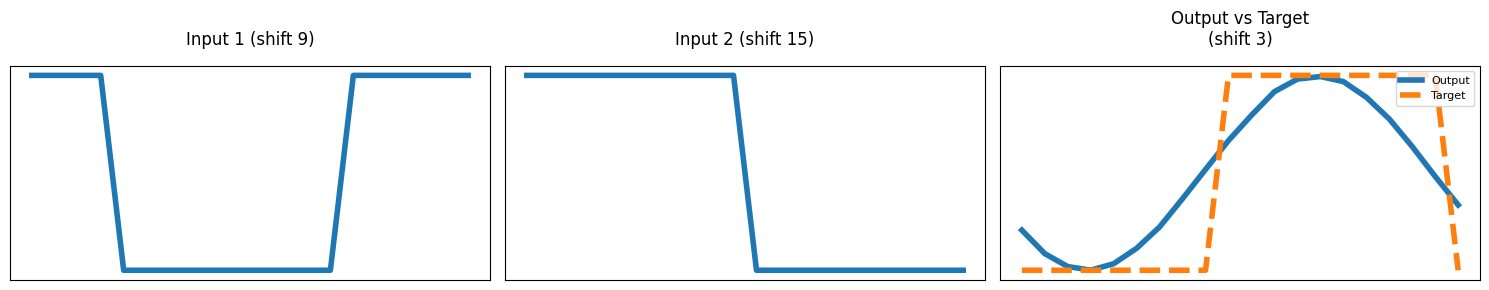

Epoch 700/3000, Loss: 0.051699


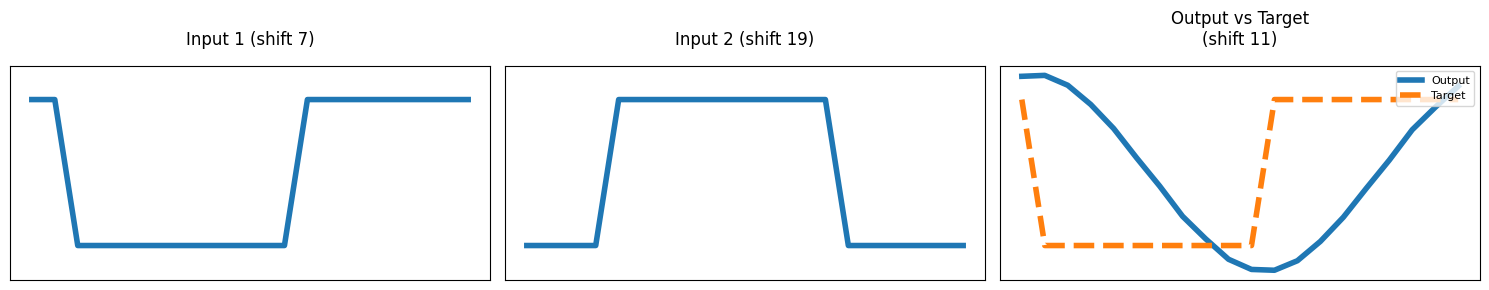

Epoch 800/3000, Loss: 0.051580


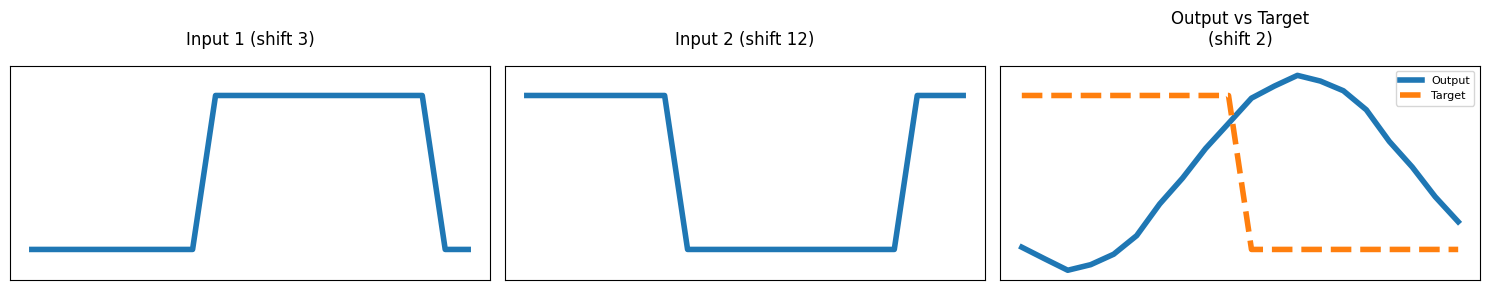

Epoch 900/3000, Loss: 0.044737


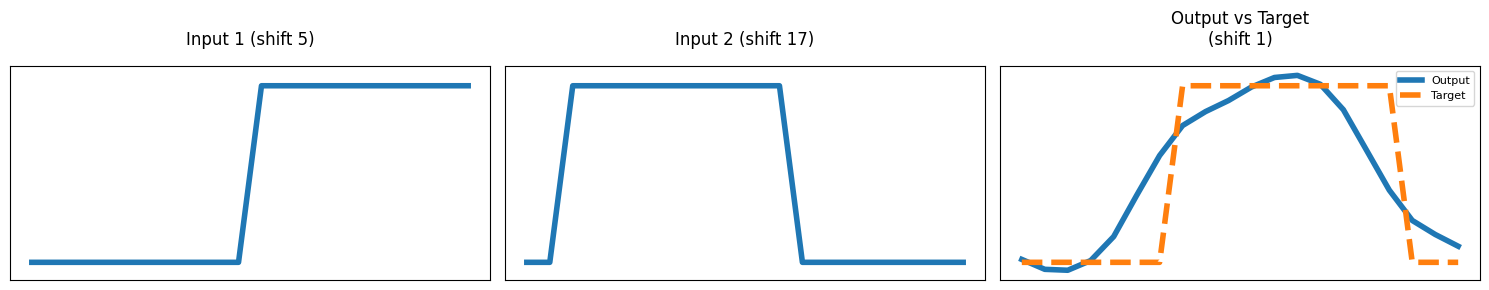

Epoch 1000/3000, Loss: 0.048336


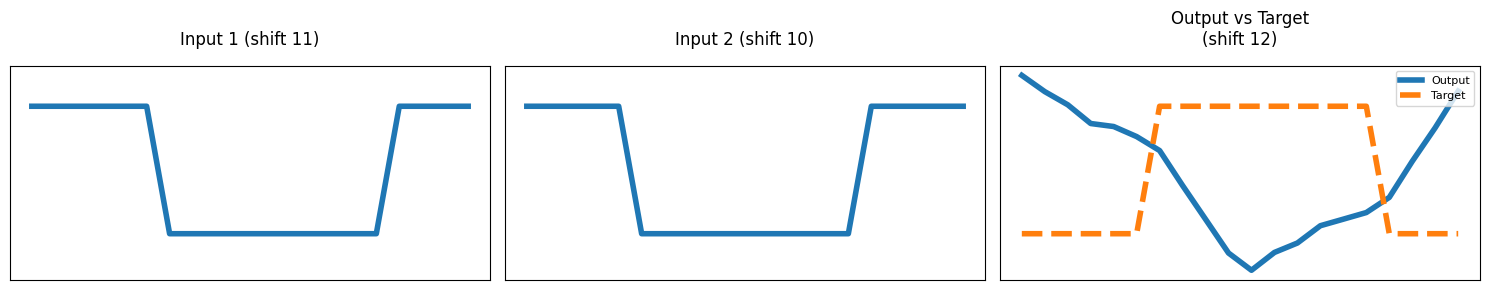

Epoch 1100/3000, Loss: 0.038575


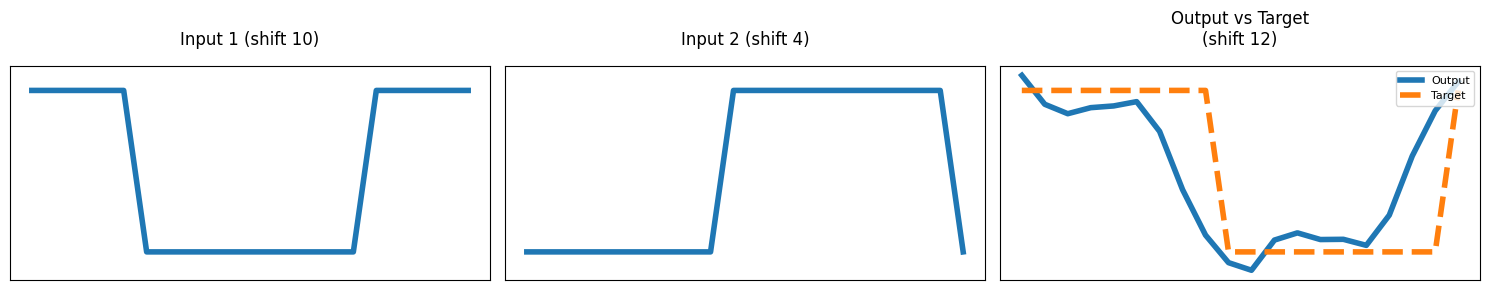

Epoch 1200/3000, Loss: 0.041989


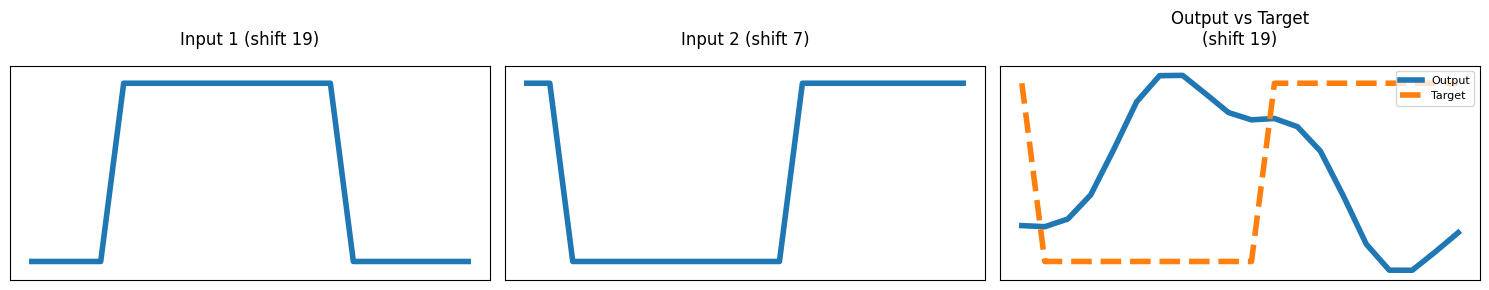

Epoch 1300/3000, Loss: 0.036825


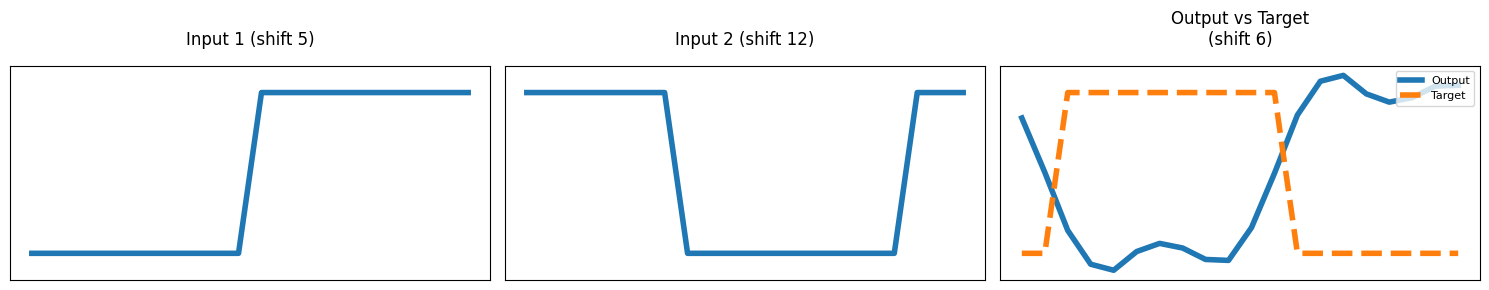

Epoch 1400/3000, Loss: 0.040352


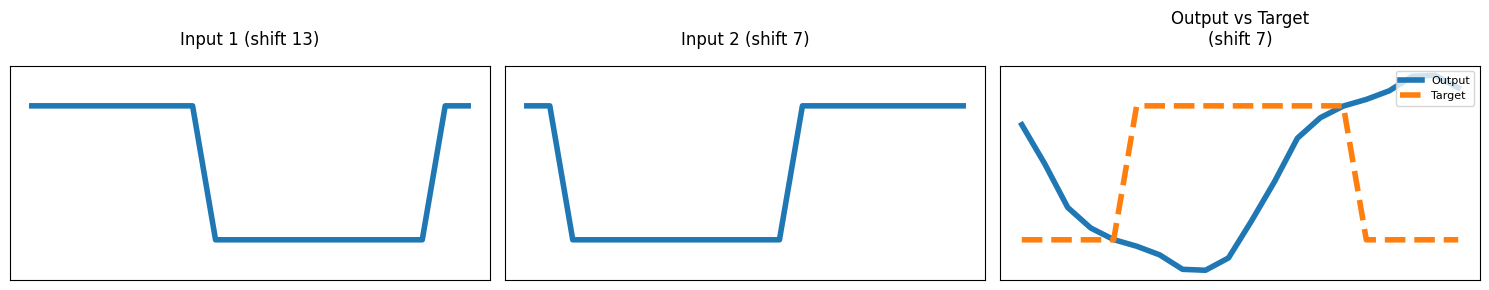

Epoch 1500/3000, Loss: 0.036589


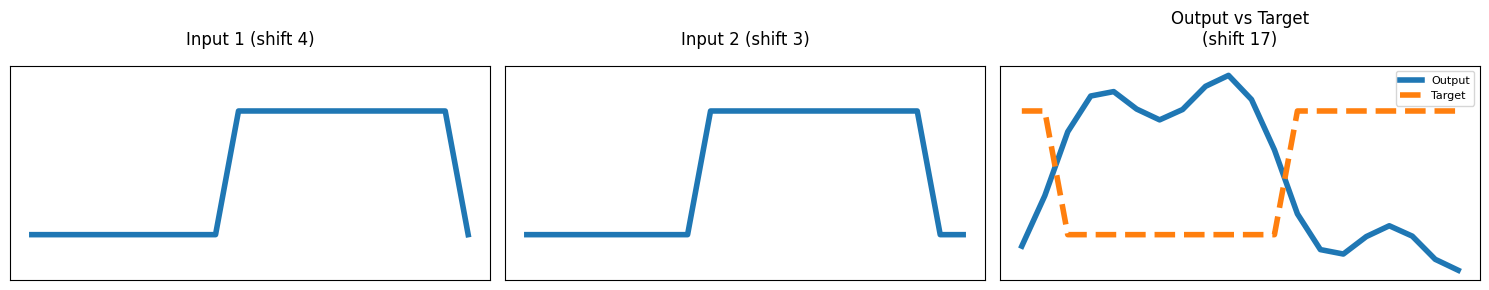

Epoch 1600/3000, Loss: 0.032430


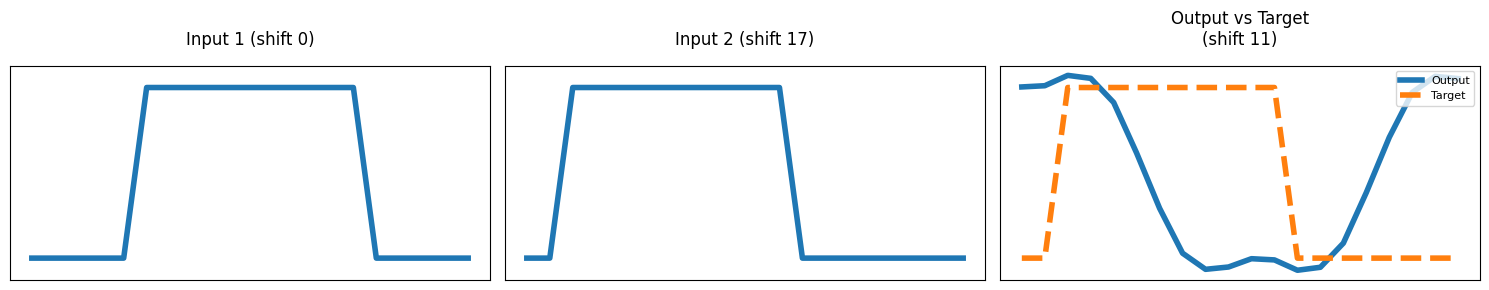

Epoch 1700/3000, Loss: 0.038328


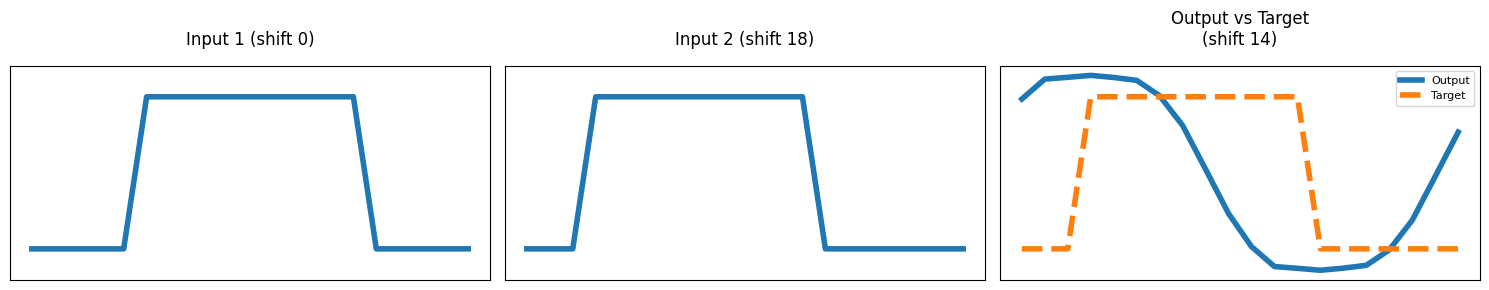

Epoch 1800/3000, Loss: 0.031759


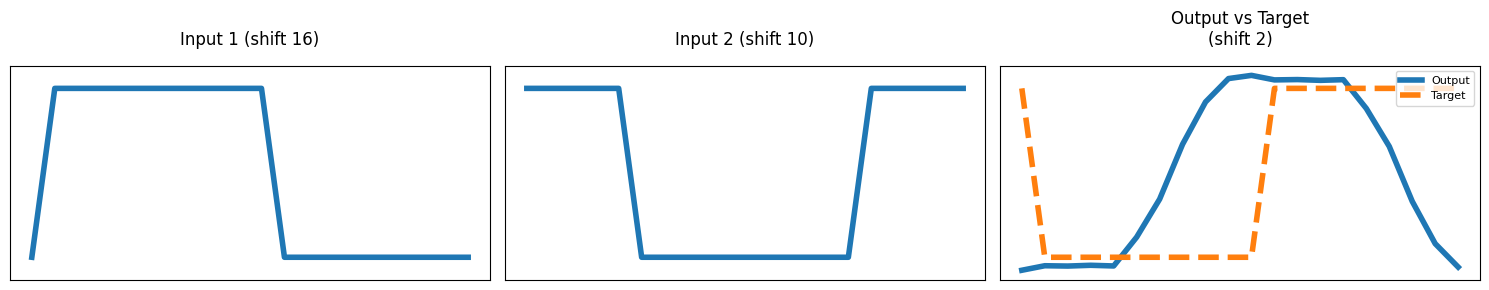

Epoch 1900/3000, Loss: 0.033099


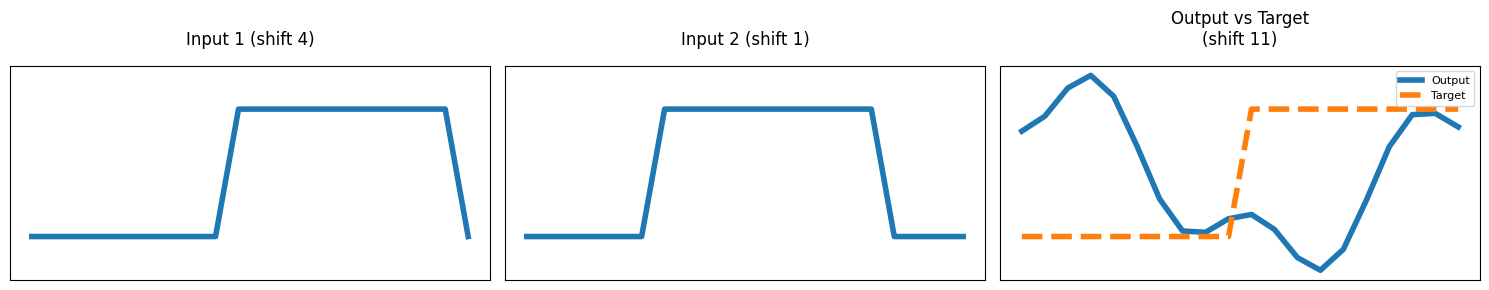

Epoch 2000/3000, Loss: 0.036034


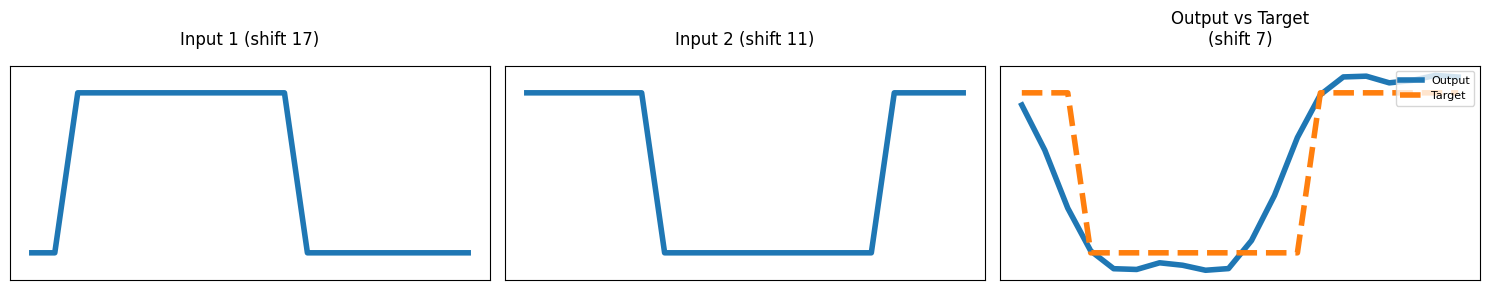

Epoch 2100/3000, Loss: 0.031850


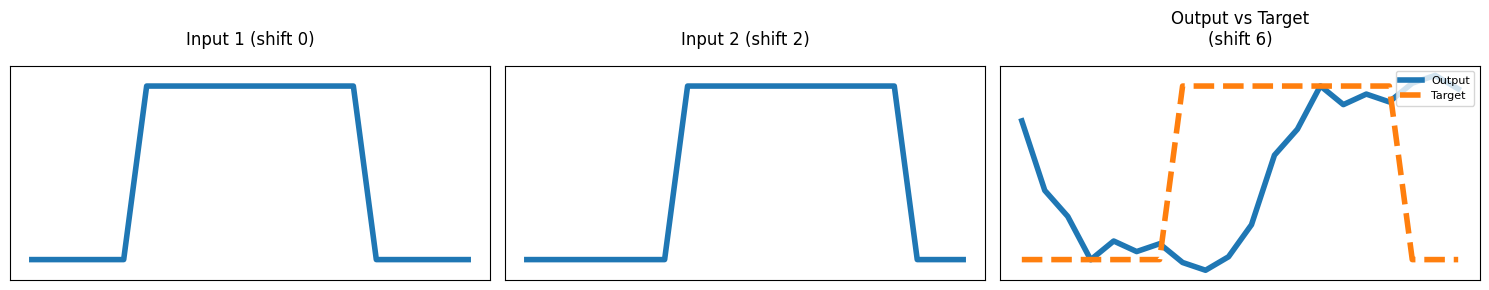

Epoch 2200/3000, Loss: 0.031670


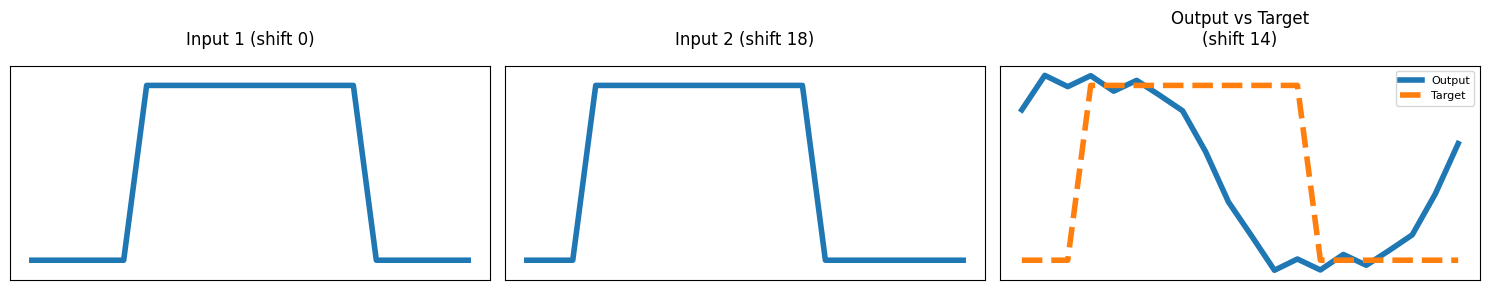

Epoch 2300/3000, Loss: 0.033758


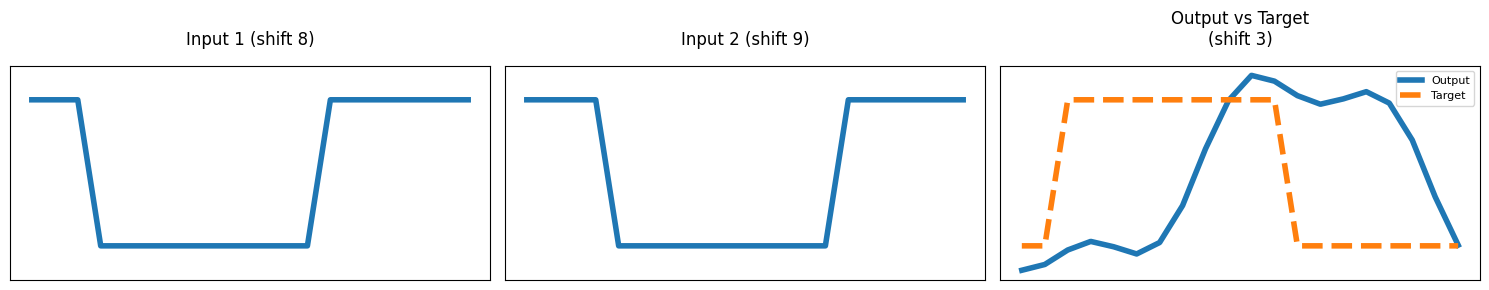

Epoch 2400/3000, Loss: 0.032735


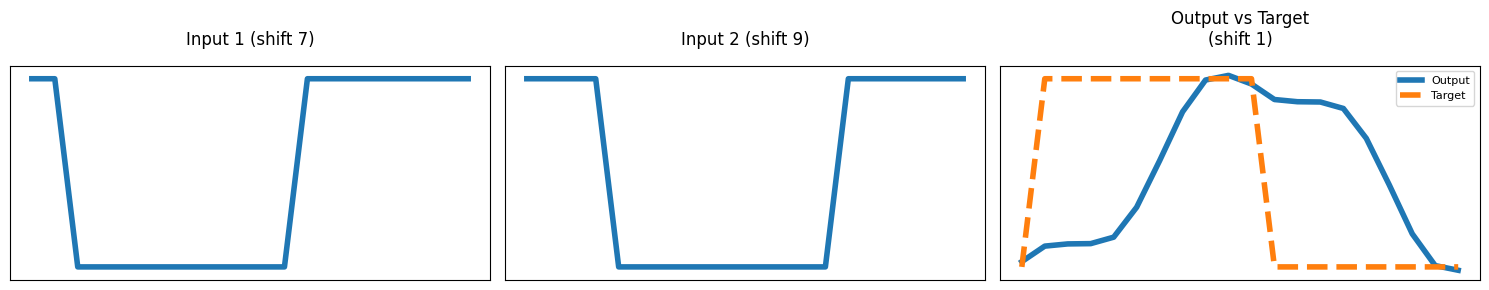

Epoch 2500/3000, Loss: 0.032134


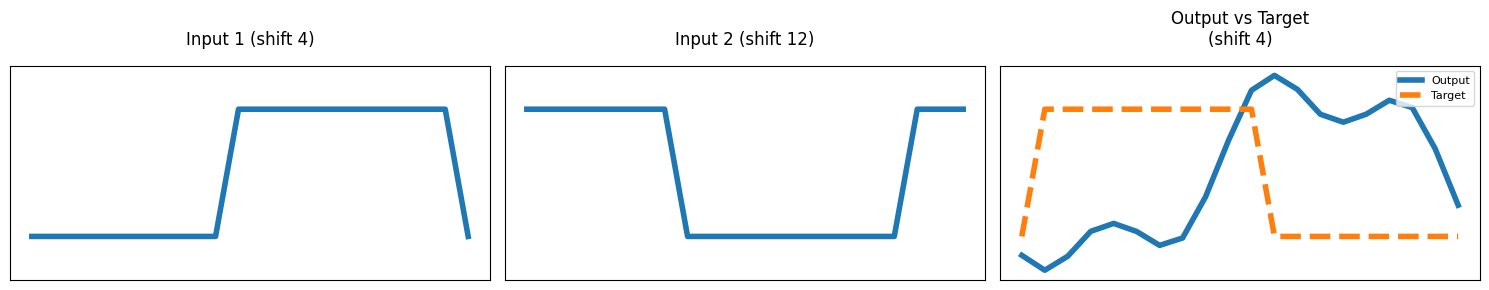

Epoch 2600/3000, Loss: 0.032199


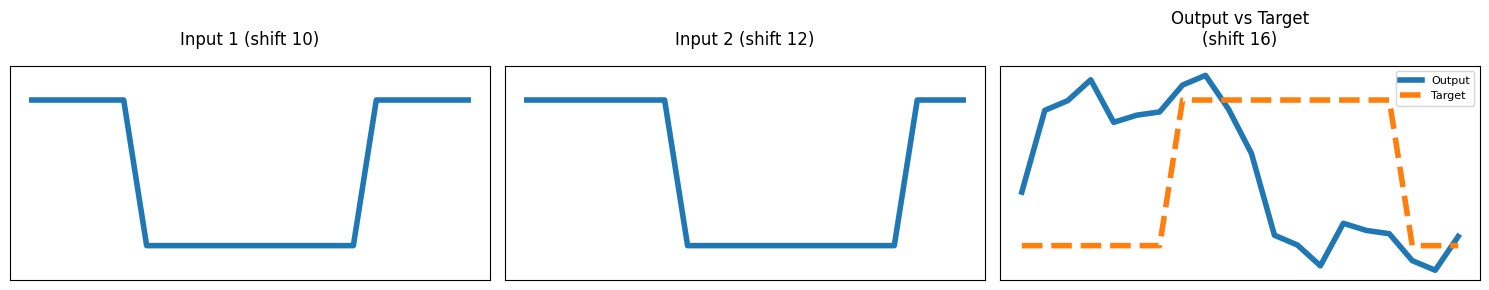

Epoch 2700/3000, Loss: 0.033508


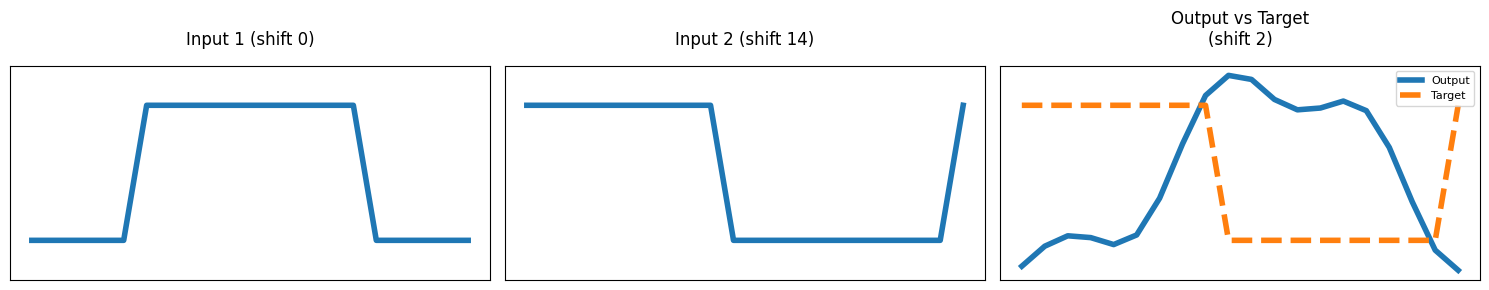

Epoch 2800/3000, Loss: 0.031521


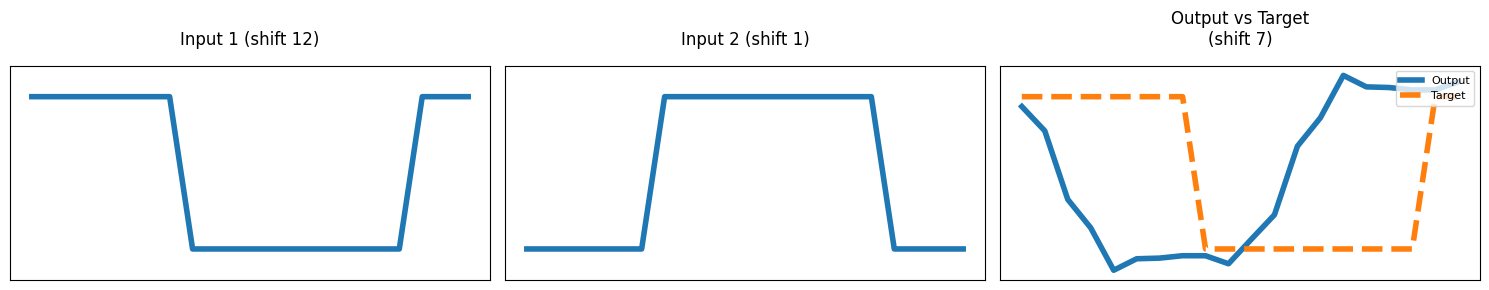

Epoch 2900/3000, Loss: 0.030663


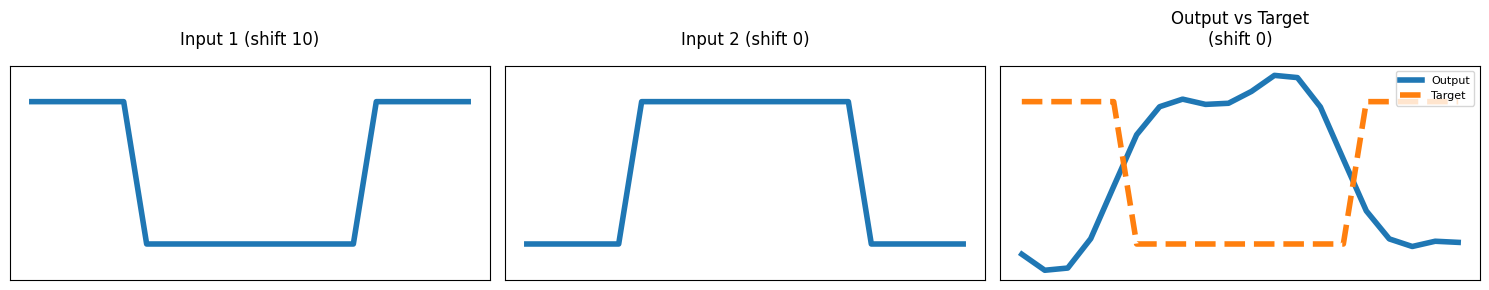

Epoch 3000/3000, Loss: 0.033576


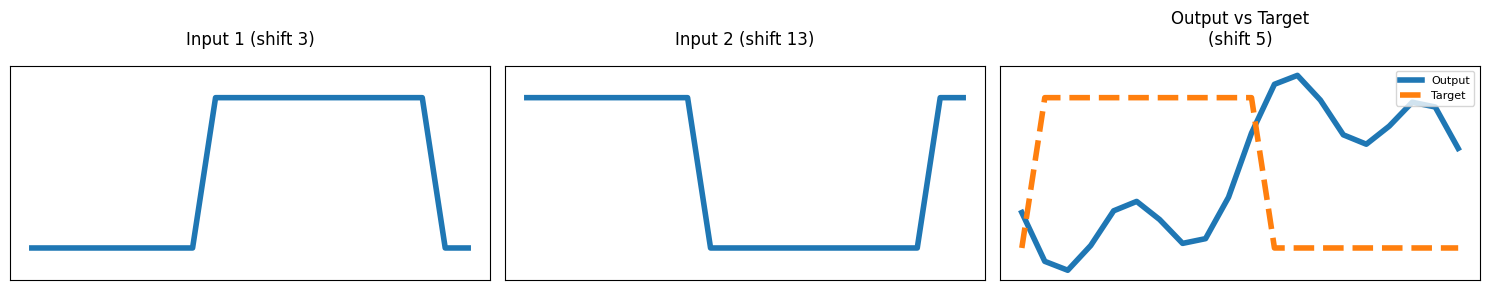

In [10]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdditionArrays(n, mi=mi, mj=mj).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
n_epochs = 3000
losses = []
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)  # Add this line to store the average loss

    # Plot results
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}')
        model.eval()
        with torch.no_grad():
            # Get two random examples
            idx1, idx2 = np.random.randint(0, len(arrays), 2)
            x = torch.cat([torch.FloatTensor(arrays[idx1]), 
                          torch.FloatTensor(arrays[idx2])]).to(device)
            output = model(x).cpu().numpy()
            target = arrays[(shifts[idx1] + shifts[idx2]) % n]
            
            plt.rcParams.update({'font.size': 10})  # Increased font size from 14 to 18
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
            
            plt.subplot(131)
            plt.plot(arrays[idx1], linewidth=4)  # Increased linewidth from 3 to 4
            plt.title(f'Input 1 (shift {shifts[idx1]})', pad=15)
            plt.xticks([])
            plt.yticks([])
            
            plt.subplot(132)
            plt.plot(arrays[idx2], linewidth=4)  # Increased linewidth from 3 to 4
            plt.title(f'Input 2 (shift {shifts[idx2]})', pad=15)
            plt.xticks([])
            plt.yticks([])
            
            plt.subplot(133)
            plt.plot(output, label='Output', linewidth=4)  # Increased linewidth from 3 to 4
            plt.plot(target, '--', label='Target', linewidth=4)  # Increased linewidth from 3 to 4
            plt.title(f'Output vs Target\n(shift {(shifts[idx1]*mi + shifts[idx2]*mj) % n})', pad=15)
            plt.xticks([])
            plt.yticks([])
            plt.legend(fontsize=8, loc='upper right')  # Increased legend fontsize from 12 to 14
            
            plt.tight_layout()
            plt.show()

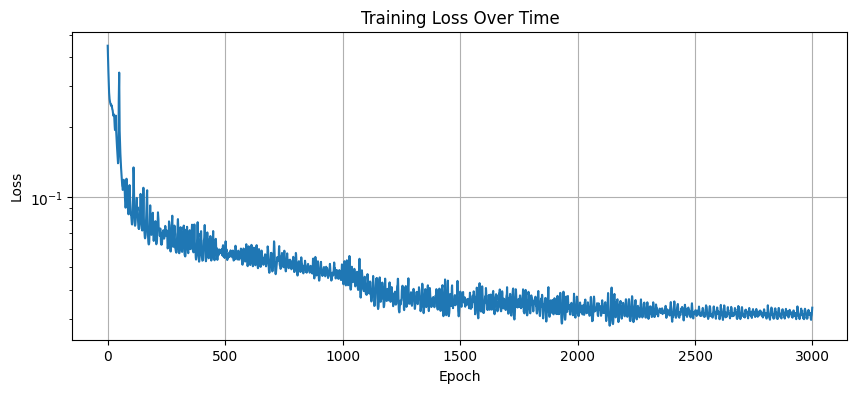

In [11]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Using log scale since loss typically decreases exponentially
plt.grid(True)
plt.show()

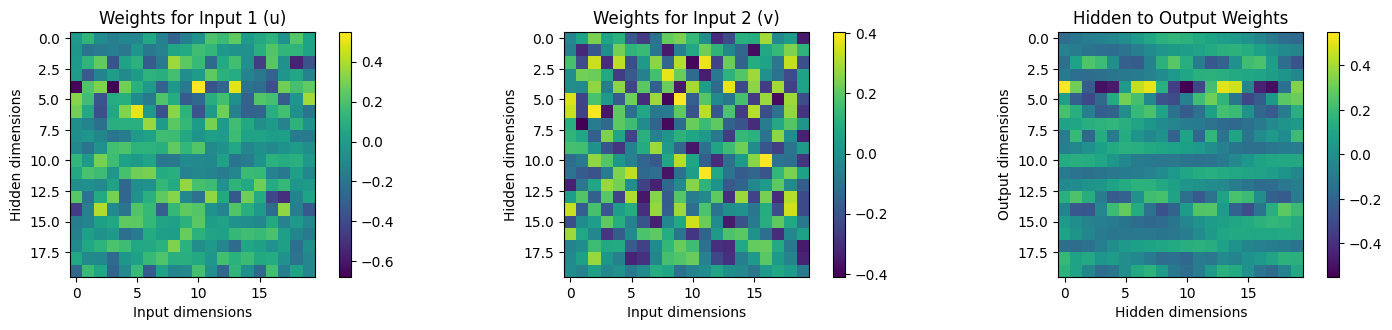

In [12]:
# Get the model weights
weights = []
for name, param in model.named_parameters():
    if 'weight' in name:
        weights.append(param.detach().cpu().numpy())

# Create figure with subplots for heatmaps
plt.figure(figsize=(15, 6))

# Plot weights for first input array - heatmap
plt.subplot(231)
plt.imshow(weights[0][:,:n], cmap='viridis')
plt.colorbar()
plt.title('Weights for Input 1 (u)')
plt.xlabel('Input dimensions')
plt.ylabel('Hidden dimensions')

# Plot weights for second input array - heatmap
plt.subplot(232)
plt.imshow(weights[0][:,n:], cmap='viridis')
plt.colorbar()
plt.title('Weights for Input 2 (v)')
plt.xlabel('Input dimensions')
plt.ylabel('Hidden dimensions')

# Plot weights from hidden to output - heatmap
plt.subplot(233)
plt.imshow(weights[1].T, cmap='viridis')
plt.colorbar()
plt.title('Hidden to Output Weights')
plt.xlabel('Hidden dimensions')
plt.ylabel('Output dimensions')

plt.tight_layout()


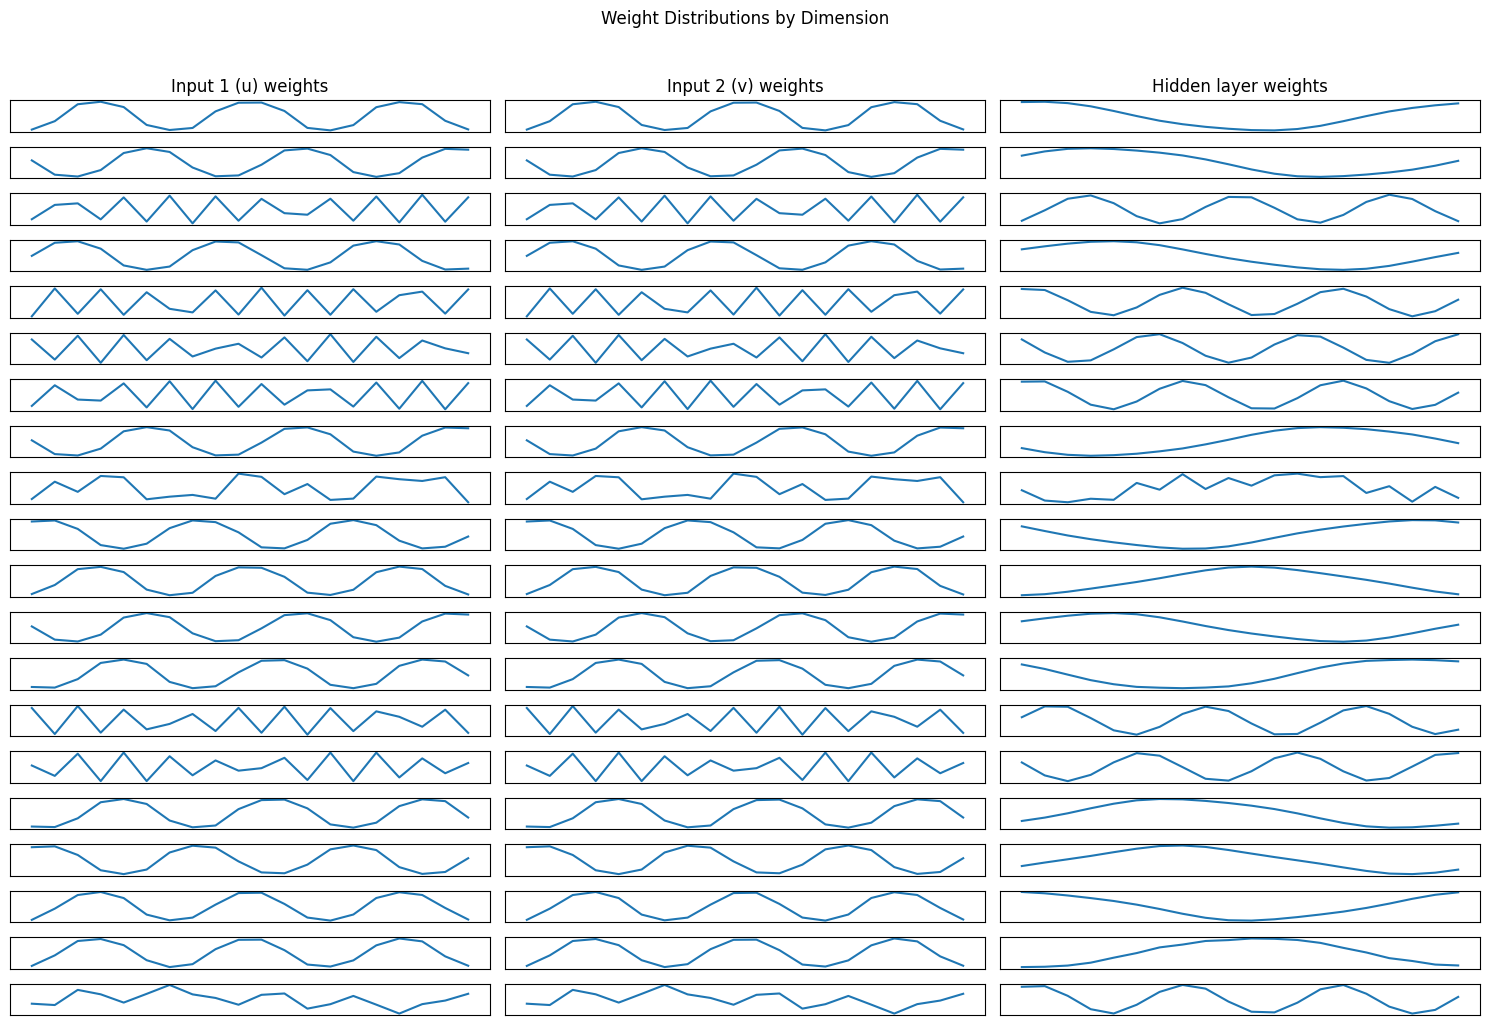

In [13]:
# Create figure with subplots for line plots
fig, axes = plt.subplots(20, 3, figsize=(15, 10))
fig.suptitle('Weight Distributions by Dimension', y=1.02)

# Plot each dimension as a line plot
for i in range(20):
    # Plot weights for first input array
    axes[i,0].plot(arrays @ weights[0][i,n:])
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    # Plot weights for second input array
    axes[i,1].plot(arrays @ weights[0][i,n:])
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    
    # Plot weights from hidden to output
    axes[i,2].plot(arrays @ weights[1][:,i])
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])

# Add column labels at the top
axes[0,0].set_title('Input 1 (u) weights')
axes[0,1].set_title('Input 2 (v) weights') 
axes[0,2].set_title('Hidden layer weights')

plt.tight_layout()
plt.show()

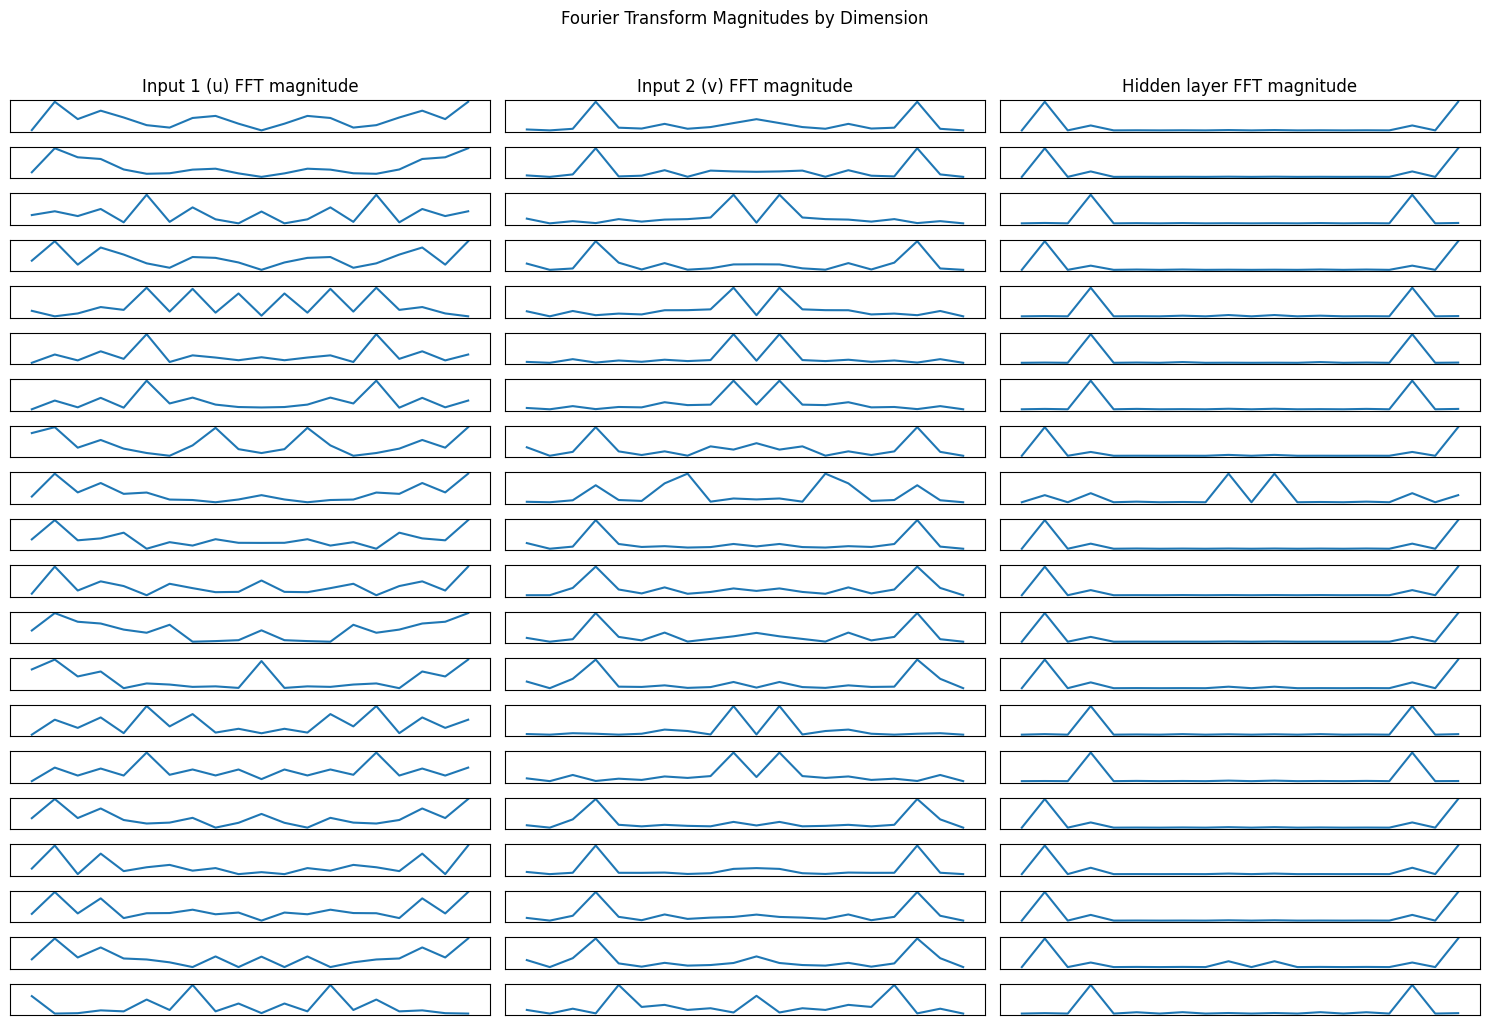

In [14]:
# Create figure with subplots for FFT magnitude plots
fig, axes = plt.subplots(20, 3, figsize=(15, 10))
fig.suptitle('Fourier Transform Magnitudes by Dimension', y=1.02)

# Plot FFT magnitude for each dimension
for i in range(20):
    # FFT for first input array weights
    fft_u = np.abs(np.fft.fft(weights[0][i,:n]))
    axes[i,0].plot(fft_u)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    # FFT for second input array weights
    fft_v = np.abs(np.fft.fft(weights[0][i,n:]))
    axes[i,1].plot(fft_v)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    
    # FFT for hidden to output weights
    fft_h = np.abs(np.fft.fft(weights[1][:,i]))
    axes[i,2].plot(fft_h)
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])

# Add column labels at the top
axes[0,0].set_title('Input 1 (u) FFT magnitude')
axes[0,1].set_title('Input 2 (v) FFT magnitude')
axes[0,2].set_title('Hidden layer FFT magnitude')

plt.tight_layout()
plt.show()
